# Customer churn

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.  
One of the most common problems gyms and other services face is customer churn.  
In order to fight churn, Model Fitness has digitized a number of its customer profiles. My task is to analyze them and come up with a customer retention strategy.  
  
To accomplish the task I have to:  

1. carry out an EDA.
1. Build a model to predict user churn
1. Create user clusters

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import plotly.express as px

In [2]:
try:
    df = pd.read_csv('gym_churn_us.csv')

except:
    df = pd.read_csv('/datasets/gym_churn_us.csv') 

# EDA

Lets look if there are any missing values in the data set, and what is the mean and standard devision. I'll use describe method. 

## Missing values 

In [3]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


We see that there are no missing values, and we have a nice view of the standard devision and mean of every category.  

Now lets compare the mean values of the groups of people who left the group that stayed.

## Churn / Un-Chuurn

Now we will divide the data to churn and unchurn and see what are the main diffrences between the groups. 

In [4]:
churn = df[df['Churn'] == 1]
unchurn = df[df['Churn'] == 0]
churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


In [5]:
unchurn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


We see a difference when it comes to the mean of people who work at partner companies and regular customers, 35% of those who left are in partner companies and 53% of those who stayed are in partner companies. Looks like that if you get a partner discount the chances of stain are bigger.  

The chances of a customer staying are 3 times bigger if he used a promo code.  

We also see that costumers with a lunger contract period will stay for longer, 5 months mean compared to 1.7 months.  

The percentage of users who go to group visits are higher in the group of unchurn then the churn.  

People who stay have a bigger mean when it comes to there life time stay at the gym.  

And finely, there is a higher class frequency with people who stayed.

## Feature distribution

in the graphs below, we can see all the statements from before materialize.

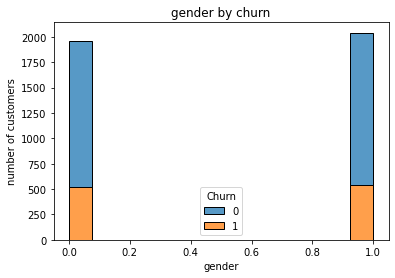

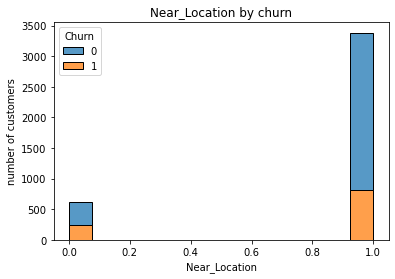

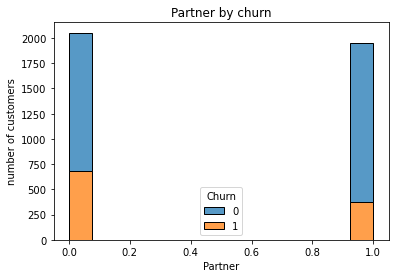

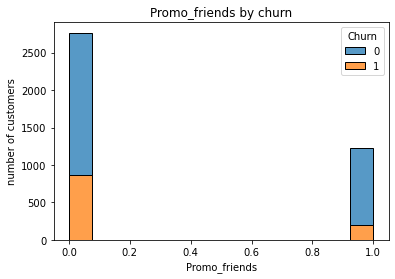

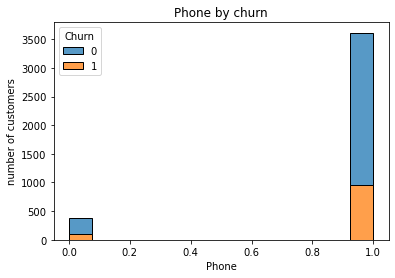

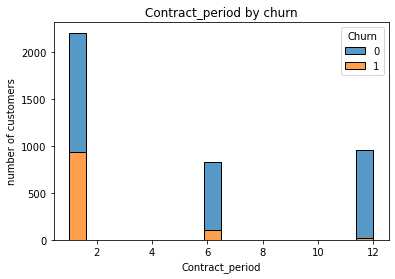

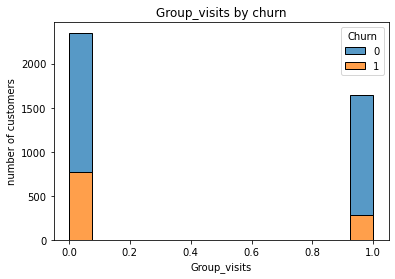

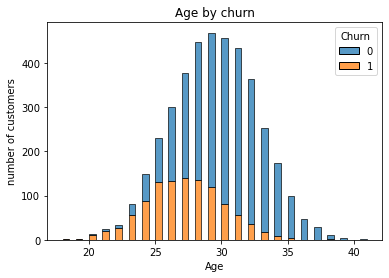

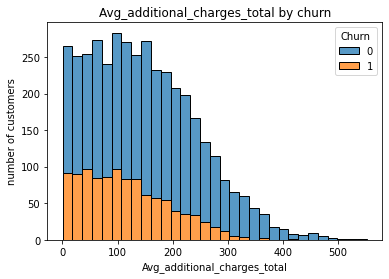

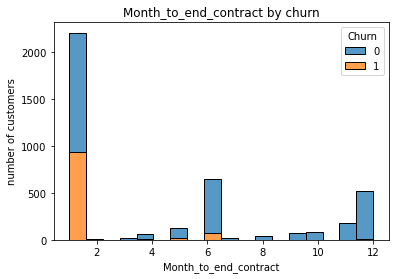

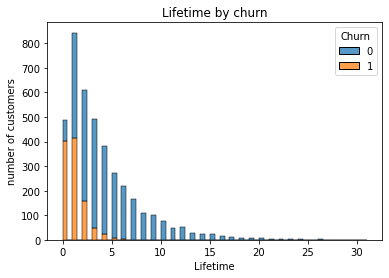

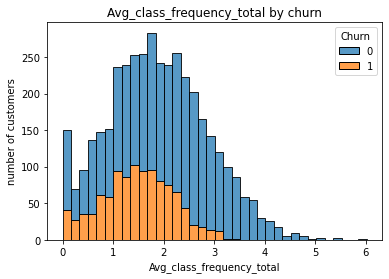

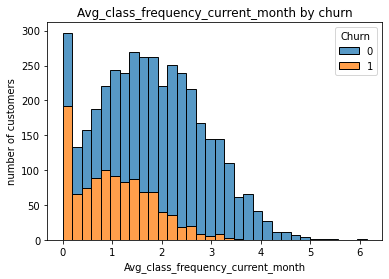

In [6]:
for col in df.drop('Churn', axis=1).columns:
    sns.histplot(df, x= col, hue = 'Churn', multiple="stack").set(title= col + ' by churn')
    plt.xlabel(col)
    plt.ylabel('number of customers')
    plt.show()

## correlation

Using the corr method, lets find if there are any strong corralations to churn.

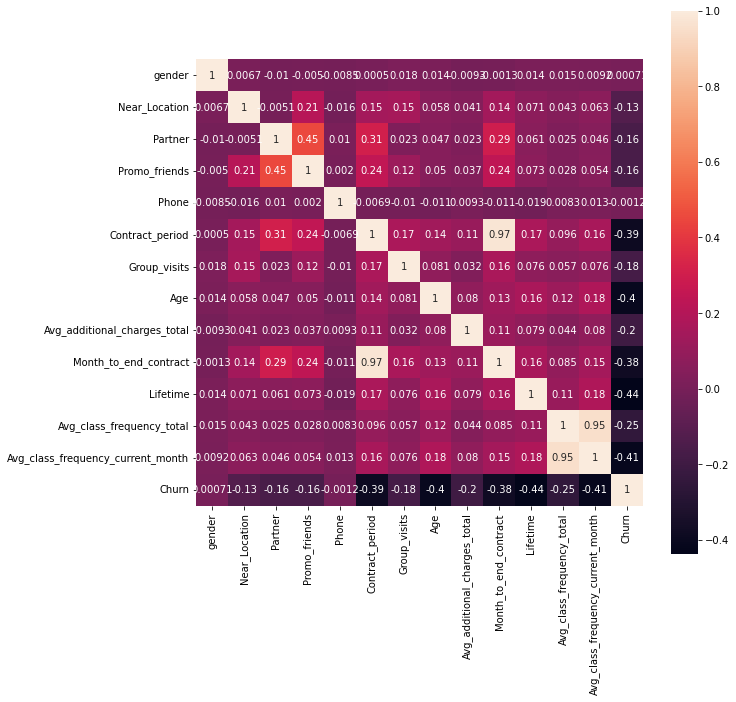

In [7]:
corr = df.corr()
fig, ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, square=True, ax=ax)
ax.set_ylim(14,0)
plt.show()

From this correlation chart, there is no feature that is strongly correlated to Churn. 

# model to predict user churn

lets create a model that will predict the churn.  
First I will divide the data into train and validation sets using the train_test_split() function.

In [8]:
X = df.drop('Churn', axis = 1)
y = df['Churn']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

Now, I'll train the model on the train set with two methods:  
logistic regression  
and random forest

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators = 100,random_state=0)

Now I'll evaluate accuracy, precision, and recall for both models using the validation data, I'll Use them to compare the models.

In [10]:
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'
          .format(accuracy_score(y_test, predictions)
                  ,precision_score(y_test, predictions)
                  ,recall_score(y_test, predictions)))

Accuracy: 0.92 Precision: 0.84 Recall: 0.81


In [11]:
model_r = LogisticRegression(random_state=0)

model_r.fit(X_train_st, y_train)
predictions = model_r.predict(X_test_st)
print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'
          .format(accuracy_score(y_test, predictions)
                  ,precision_score(y_test, predictions)
                  ,recall_score(y_test, predictions)))

Accuracy: 0.92 Precision: 0.85 Recall: 0.83


Seems like logistic regression gave a better result.

# User clusters

## number of clusters 

To create user clusters, lets first standardize the data

In [12]:
X_sc =  scaler.fit_transform(X)

Now I'll Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram

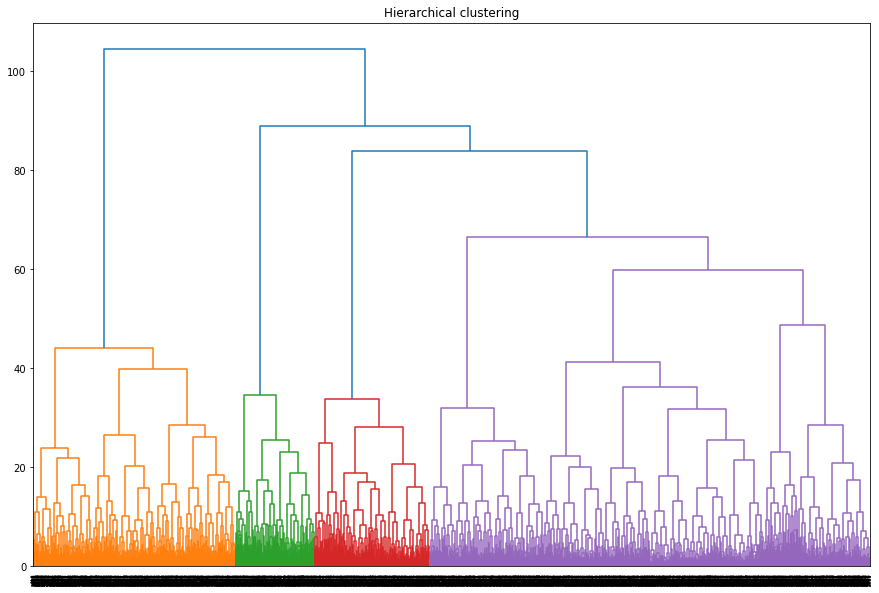

In [13]:
linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering')
plt.show()

From the resulting graph, I estimate that I can single out 4 clusters.

## Predict customer clusters

Lets train the clustering model with the K-means algorithm and predict customer clusters.

In [14]:
x_pc = scaler.fit_transform(X)

km = KMeans(n_clusters = 5)
labels = km.fit_predict(x_pc)

X['cluster_km'] = labels
X.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,4
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,1
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,1
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,4


Now I'll look at the mean feature values for clusters.

In [15]:
df_clus = X.groupby(['cluster_km']).mean()
df_clus

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.496324,0.000000,0.466912,0.077206,0.915441,2.209559,0.215074,28.483456,133.630215,2.073529,2.781250,1.657657,1.466870
1,0.500000,0.944563,0.740938,0.486141,0.899787,11.872068,0.552239,29.932836,164.865058,10.866738,4.698294,2.000230,1.991555
2,0.585938,0.971354,0.260417,0.092448,0.903646,2.813802,0.477865,30.144531,162.010722,2.589844,5.132812,2.883403,2.884764
3,0.488267,1.000000,0.243682,0.020758,0.902527,1.985560,0.320397,28.209386,131.191160,1.901625,2.398917,1.272734,1.030315
4,0.484424,0.998442,0.822430,1.000000,0.900312,3.155763,0.454829,29.218069,141.203442,2.919003,3.705607,1.734352,1.627826


There are big differences in Month_to_end_contract and Contract_period between the clusters.

## Distributions of features

Lets plot distributions of features for the clusters.  
First we will divide the data to numerical and categorical data.

In [28]:
categorical = X[['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits']]
numerical = X[['Age','Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total']]

To see the properties for the numerical group, I'm going to use boxplots.

In [29]:
for i in numerical.columns:
    plot = px.box(X ,x = 'cluster_km', y = i, title = i + ' cluster')
    plot.show()

Lets dissect the properties of each numeric cluster by feature:  
Age- the oldest median is clusters 1 and 2  with 30, and the youngest is 28 in group 3.  
Avg_additional_charges_total- cluster 1 has the highest mean with a 160$ of additional charges, and the lowest is group 3 with 118.  
Month_to_end_contract- all the clusters exsept group 1 have 1 month left, while cluster 1 has 12 as its' median.  
Lifetime - the highest median is of groups 1 and 2 at 4 months, while the lowest is at group 3 with just a month.  
Avg_class_frequency_total- the highst median of class frequency is of cluster 2 with 2.76 class a month, wihle group 3 is only 1.3 class a month.  

Now lets do the same thing for the categorical data, using histograms.

In [30]:
for i in categorical.columns:
    hist = px.histogram(X ,x = 'cluster_km', color = i, title = i + ' cluster')
    hist.show()

gender - has almost a half men half women divide in all clusters.  
Near_Location - all clusters but cluster 0, are living near by.  
Partner - clusters 1 and 4 have a large percentage of people who work at partner companys, in comper to people who don't.  
Promo_friends - all clusters but cluster 4 have a larger number of people who signed in through a friend, comperd to thows how did not.  
Group_visits - all clusters, but cluster 1, have a larger number of users that did not attend group visits, especially cluster 3.

## Churn rate for each cluster

Using the groupby() method, we see the average churn probabilaty for each cluster.

In [32]:
df['cluster_km'] = labels
churn_rate = df.groupby('cluster_km')['Churn'].mean()
churn_rate

cluster_km
0    0.450368
1    0.022388
2    0.069010
3    0.526173
4    0.247664
Name: Churn, dtype: float64

Looking at the results, we can see that the clusters with the lowest probabilaty of churn are 1, with a 2.2% chance of churn, and 2, with a 6.9% chance of churn. Clusters 3 and 0, have the highest chance of churn, 45% for cluster 0 and 52% for cluster 3.

# Summary 

1. In the EDA stage I:
    1. cheked for missing values, using the describe() method.
    1. divided the data to churn and unchurn and see what are the main diffrences between the groups.
    1. Used the corr method, to find if there are any strong corralations to churn.  
1. In the model to predict user churn I:
    1. created a model that will predict the churn.  
       First I divided the data into train and validation sets using the train_test_split() function.  
       I trained the model on the train set with two methods: logistic regression, and random forest.  
       I evaluated the accuracy, precision, and recall for both models using the validation data,  
       I Used them to compare the models.
1. In user clusters I:  
    1. Used the linkage() function to build a matrix of distances based on the standardized feature matrix,  
       and ploted a dendrogram.  
    1. trained the clustering model with the K-means algorithm and predicted customer clusters.
       Then I looked at the mean feature values for clusters.
    1. ploted distributions of features for the clusters.  
       First I divided the data to numerical and categorical data.  
       To see the properties for the numerical group, I used boxplots.
       I did the same thing for the categorical data, using histograms.
    1. Used the groupby() method, to see the average churn probabilaty for each cluster.

## Conclusion

By going over each clusters churn rate, we see that cluster 3 has the highest churn reate at above 50%.  
We see that cluster 3 spends the lowest amount of additional charges, the gym needs to think of ways to get them more involved with gym activitys.  
We see that in cluster 3, the members have a very short life time membership. Maybe the gym is not that beginner friendly, and needs to give more sepport to new commers in thier fitness journey.  
Like I pointed out before, the cluster 3 is not involved enough in gym activitis, for exampol, cluster 3 hass the lowest class attendance of all groups. The gym needs to encourage new commers to attend more clases, maybe have more commercials that present the classes.  
Same thing goes for group sessions. Having some people around, encourages people more to workout, and the gym needs to create that vibe of a friendly support gym, and encouraging more people to go to group workouts and having more commercials.  
Cluster 0 also has a high churn rate, and one of the reasons why is becouse users in that cluster live far from the gym. The gym needs to prioritize comersials to the nearby area.  
Seems like group 3 have a high percent of people how don't work partner companys, Unlike cluster 1, that has the lowest churn rate. I think that the gym can have deals with more companys, so their workers can also get a discount in memberships, and target more people how work in partner companys in general.  
Seems that promo friends is not a popular thing. the gym needs to market it more, and maybe make the discount more atractive.  